## Reference :-
https://scikit-learn.org/stable/auto_examples/text/plot_document_clustering.html#sphx-glr-auto-examples-text-plot-document-clustering-py

## Loading The the Text Data

20news

In [ ]:
import numpy as np
from sklearn.datasets import fetch_20newsgroups

In [ ]:
newsgroups_train = fetch_20newsgroups(subset='train')
categories = [
    'alt.atheism',
    'comp.graphics',
    'comp.sys.ibm.pc.hardware',
    'comp.sys.mac.hardware',
    'misc.forsale',
    'rec.autos',
    'rec.motorcycles',
    'sci.electronics',
    'talk.politics.guns',
    'talk.politics.mideast',
    'talk.religion.misc',
]

In [ ]:
datasets = fetch_20newsgroups(
    remove = ('headers','footers','quotes'),
    subset = 'all',
    categories = categories,
    shuffle=True,
    random_state=42,
)

labels = datasets.target
unique_labels, category_size = np.unique(labels, return_counts=True)
true_k = unique_labels.shape[0]
print(f"There are {len(datasets.data)} documents in {true_k} categories")

There are 10140 documents in 11 categories


## Quantifying the quality of clustering results.

## Eventhough Clustering algorithms are unsupervised learning methods. Since we have class labels for this specific dataset, it is possible to use evaluation metrics that leverage this “supervised” ground truth information to quantify the quality of the resulting clusters. Examples of such metrics are the following:

1. Homogeneity, which quantifies how much clusters contain only members of a single class;

2. Completeness, which quantifies how much members of a given class are assigned to the same clusters;

3. V-measure, the harmonic mean of completeness and homogeneity;

4. Rand-Index, which measures how frequently pairs of data points are grouped consistently according to the result of the clustering algorithm and the ground truth class assignment;

5. Adjusted Rand-Index, a chance-adjusted Rand-Index such that random cluster assignment have an ARI of 0.0 in expectation.

In [ ]:
from collections import defaultdict
from time import time

from sklearn import metrics

evaluations = []        # Empty list to store estimator name and training time
evaluations_std = []    # Empty list to store estimator name and std dev of training time


def fit_and_evaluate(km, X, name=None, n_runs=5):
    name = km.__class__.__name__ if name is None else name

    train_times = []
    scores = defaultdict(list)
    for seed in range(n_runs):
        km.set_params(random_state=seed)
        t0 = time()
        km.fit(X)
        train_times.append(time() - t0)
        scores["Homogeneity"].append(metrics.homogeneity_score(labels, km.labels_))
        scores["Completeness"].append(metrics.completeness_score(labels, km.labels_))
        scores["V-measure"].append(metrics.v_measure_score(labels, km.labels_))
        scores["Adjusted Rand-Index"].append(
            metrics.adjusted_rand_score(labels, km.labels_)
        )
        scores["Silhouette Coefficient"].append(
            metrics.silhouette_score(X, km.labels_, sample_size=2000)
        )
    train_times = np.asarray(train_times)

    print(f"clustering done in {train_times.mean():.2f} ± {train_times.std():.2f} s ")
    evaluation = {
        "estimator": name,
        "train_time": train_times.mean(),
    }
    evaluation_std = {
        "estimator": name,
        "train_time": train_times.std(),
    }
    for score_name, score_values in scores.items():
        mean_score, std_score = np.mean(score_values), np.std(score_values)
        print(f"{score_name}: {mean_score:.3f} ± {std_score:.3f}")
        evaluation[score_name] = mean_score
        evaluation_std[score_name] = std_score
    evaluations.append(evaluation)
    evaluations_std.append(evaluation_std)

## K-means clustering on text features¶
Two feature extraction methods are used:

1. TfidfVectorizer :-  maps the most frequent words to features indices and hence compute a word occurrence frequency (sparse) matrix. The word frequencies are then reweighted using the Inverse Document Frequency (IDF) vector collected feature-wise over the corpus.



## Feature Extraction using TfidfVectorizer¶

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(
    max_df=0.5,
    min_df=5,
    stop_words="english",
)
t0 = time()
X_tfidf = vectorizer.fit_transform(datasets.data)

print(f"vectorization done in {time() - t0:.3f} s")
print(f"n_samples: {X_tfidf.shape[0]}, n_features: {X_tfidf.shape[1]}")

vectorization done in 2.532 s
n_samples: 10140, n_features: 14779


## After ignoring terms that appear in more than 50% of the documents (as set by max_df=0.5) and terms that are not present in at least 5 documents (set by min_df=5), the resulting number of unique terms n_features is around 14779. We can additionally quantify the sparsity of the X_tfidf matrix as the fraction of non-zero entries divided by the total number of elements.

In [ ]:
print(f"There are {X_tfidf.nnz / np.prod(X_tfidf.shape):.3f}% entries in documents which are non-zero")


There are 0.003% entries in documents which are non-zero


## Clustering sparse data with k-means¶
- both KMeans and MiniBatchKMeans optimize a non-convex objective function
- their clustering is not guaranteed to be optimal for a given random init.
- On sparse high-dimensional data e.g. text vectorized using the Bag of Words approach,
- k-means can initialize centroids on extremely isolated data points. Those data points can stay their own centroids all along.


e.g :-



In [ ]:
from sklearn.cluster import KMeans

for seed in range(5):
    kmeans = KMeans(
        n_clusters=true_k,
        max_iter=100,
        n_init=1,
        random_state=seed,
    ).fit(X_tfidf)
    cluster_ids, cluster_sizes = np.unique(kmeans.labels_, return_counts=True)
    print(f"Number of elements assigned to each cluster: {cluster_sizes}")
print()
print(
    "True number of documents in each category according to the class labels: "
    f"{category_size}"
)

Number of elements assigned to each cluster: [ 425  522  970  180 3200  328 1316  288 1965  353  593]
Number of elements assigned to each cluster: [    1     1     1     1     1     2     3     1     1     1 10127]
Number of elements assigned to each cluster: [    1     1     1     1 10125     4     1     3     1     1     1]
Number of elements assigned to each cluster: [ 411 1430  178 3675  302 1262  383  415  579 1031  474]
Number of elements assigned to each cluster: [ 282 3974  794  876  823  573  501  643 1212   78  384]

True number of documents in each category according to the class labels: [799 973 982 963 975 990 996 984 910 940 628]


## To avoid this problem, one possibility is to increase the number of runs with independent random initiations n_init. In such case the clustering with the best inertia (objective function of k-means) is chosen.

In [ ]:
kmeans = KMeans(
    n_clusters=true_k,
    max_iter=100,
    n_init=5,
)

fit_and_evaluate(kmeans, X_tfidf, name="KMeans\non tf-idf vectors")

clustering done in 3.25 ± 1.64 s 
Homogeneity: 0.242 ± 0.110
Completeness: 0.346 ± 0.032
V-measure: 0.269 ± 0.113
Adjusted Rand-Index: 0.087 ± 0.044
Silhouette Coefficient: 0.006 ± 0.002


- All the clustering evaluation metrics have a maximum value of 1.0 (for a perfect clustering result).

- Higher values are better. Values of the Adjusted Rand-Index close to 0.0 correspond to a random labeling.

- Notice from the scores above that the cluster assignment is indeed well above chance level, but the overall quality can certainly improve.

- Keep in mind that the class labels may not reflect accurately the document topics and therefore metrics that use labels are not necessarily the best to evaluate the quality of our clustering pipeline

## Performing dimensionality reduction using LSA¶
- A n_init=1 can still be used as long as the dimension of the vectorized space is reduced first to make k-means more stable.
- For such purpose we use TruncatedSVD, which works on term count/tf-idf matrices.

- SVD results are not normalized, we redo the normalization to improve the KMeans result.

- Using SVD to reduce the dimensionality of TF-IDF document vectors is often known as latent semantic analysis (LSA) in the information retrieval and text mining literature.

In [ ]:
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

lsa = make_pipeline(TruncatedSVD(n_components=100), Normalizer(copy=False))
t0 = time()
X_lsa = lsa.fit_transform(X_tfidf)
explained_variance = lsa[0].explained_variance_ratio_.sum()

print(f"LSA done in {time() - t0:.3f} s")
print(f"Explained variance of the SVD step: {explained_variance * 100:.1f}%")

LSA done in 2.507 s
Explained variance of the SVD step: 12.6%


## Using a single initialization means the processing time will be reduced for both KMeans and MiniBatchKMeans.

In [ ]:
kmeans = KMeans(
    n_clusters=true_k,
    max_iter=100,
    n_init=1,
)

fit_and_evaluate(kmeans, X_lsa, name="KMeans\nwith LSA on tf-idf vectors")

clustering done in 0.56 ± 0.50 s 
Homogeneity: 0.340 ± 0.010
Completeness: 0.394 ± 0.013
V-measure: 0.365 ± 0.009
Adjusted Rand-Index: 0.179 ± 0.014
Silhouette Coefficient: 0.046 ± 0.003


- Clustering on the LSA representation of the document is significantly faster (both because of n_init=1 and because the dimensionality of the LSA feature space is much smaller).

- Furthermore, all the clustering evaluation metrics have improved. We repeat the experiment with MiniBatchKMeans.

In [ ]:
from sklearn.cluster import MiniBatchKMeans

minibatch_kmeans = MiniBatchKMeans(
    n_clusters=true_k,
    n_init=1,
    init_size=1000,
    batch_size=1000,
)

fit_and_evaluate(
    minibatch_kmeans,
    X_lsa,
    name="MiniBatchKMeans\nwith LSA on tf-idf vectors",
)

clustering done in 0.19 ± 0.02 s 
Homogeneity: 0.281 ± 0.057
Completeness: 0.346 ± 0.041
V-measure: 0.308 ± 0.046
Adjusted Rand-Index: 0.160 ± 0.054
Silhouette Coefficient: 0.038 ± 0.005


## Top terms per cluster¶
- TfidfVectorizer can be inverted we can identify the cluster centers, which provide an intuition of the most influential words for each cluster.

In [ ]:
original_space_centroids = lsa[0].inverse_transform(kmeans.cluster_centers_)
order_centroids = original_space_centroids.argsort()[:, ::-1]
terms = vectorizer.get_feature_names_out()

for i in range(true_k):
    print(f"Cluster {i}: ", end="")
    for ind in order_centroids[i, :10]:
        print(f"{terms[ind]} ", end="")
    print()

Cluster 0: card monitor video apple bus bit mac board ram memory 
Cluster 1: people god don israel say think gun jews said just 
Cluster 2: car bike engine cars just like new good miles don 
Cluster 3: cheers kent jesus sorry religion time life christian book don 
Cluster 4: just don like think use ve good know com edu 
Cluster 5: modem port serial ports fax mac data pc software use 
Cluster 6: 00 50 sale 10 20 shipping 1st price interested new 
Cluster 7: thanks does know graphics looking advance program help image mail 
Cluster 8: fbi koresh batf compound did children government gas evidence bd 
Cluster 9: drive scsi hard disk drives ide controller floppy cd thanks 
Cluster 10: sale offer shipping condition asking new email price sell best 


## HashingVectorizer¶
- An alternative vectorization can be done using a HashingVectorizer instance, which does not provide IDF weighting as this is a stateless model (the fit method does nothing).
- When IDF weighting is needed it can be added by pipelining the HashingVectorizer output to a TfidfTransformer instance.
- In this case we also add LSA to the pipeline to reduce the dimension and sparcity of the hashed vector space.

In [ ]:
from sklearn.feature_extraction.text import HashingVectorizer, TfidfTransformer

lsa_vectorizer = make_pipeline(
    HashingVectorizer(stop_words="english", n_features=1_000_000),
    TfidfTransformer(),
    TruncatedSVD(n_components=100, random_state=0),
    Normalizer(copy=False),
)

t0 = time()
X_hashed_lsa = lsa_vectorizer.fit_transform(datasets.data)
print(f"vectorization done in {time() - t0:.3f} s")

vectorization done in 77.084 s


## The LSA step takes a relatively long time to fit, especially with hashed vectors.
- The reason is that a hashed space is typically large (set to n_features=1_000_000 in this example).
- One can try lowering the number of features at the expense of having a larger fraction of features with hash collisions as shown in the example notebook FeatureHasher and DictVectorizer Comparison.

## We now fit and evaluate the kmeans and minibatch_kmeans instances on this hashed-lsa-reduced data:

In [ ]:
fit_and_evaluate(kmeans, X_hashed_lsa, name="KMeans\nwith LSA on hashed vectors")

clustering done in 0.65 ± 0.50 s 
Homogeneity: 0.342 ± 0.023
Completeness: 0.384 ± 0.029
V-measure: 0.362 ± 0.024
Adjusted Rand-Index: 0.203 ± 0.022
Silhouette Coefficient: 0.044 ± 0.005


In [ ]:
fit_and_evaluate(
    minibatch_kmeans,
    X_hashed_lsa,
    name="MiniBatchKMeans\nwith LSA on hashed vectors",
)

clustering done in 0.19 ± 0.01 s 
Homogeneity: 0.298 ± 0.053
Completeness: 0.347 ± 0.036
V-measure: 0.319 ± 0.042
Adjusted Rand-Index: 0.174 ± 0.058
Silhouette Coefficient: 0.031 ± 0.018


- Both methods lead to good results that are similar to running the same models on the traditional LSA vectors (without hashing)

## Clustering evaluation summary

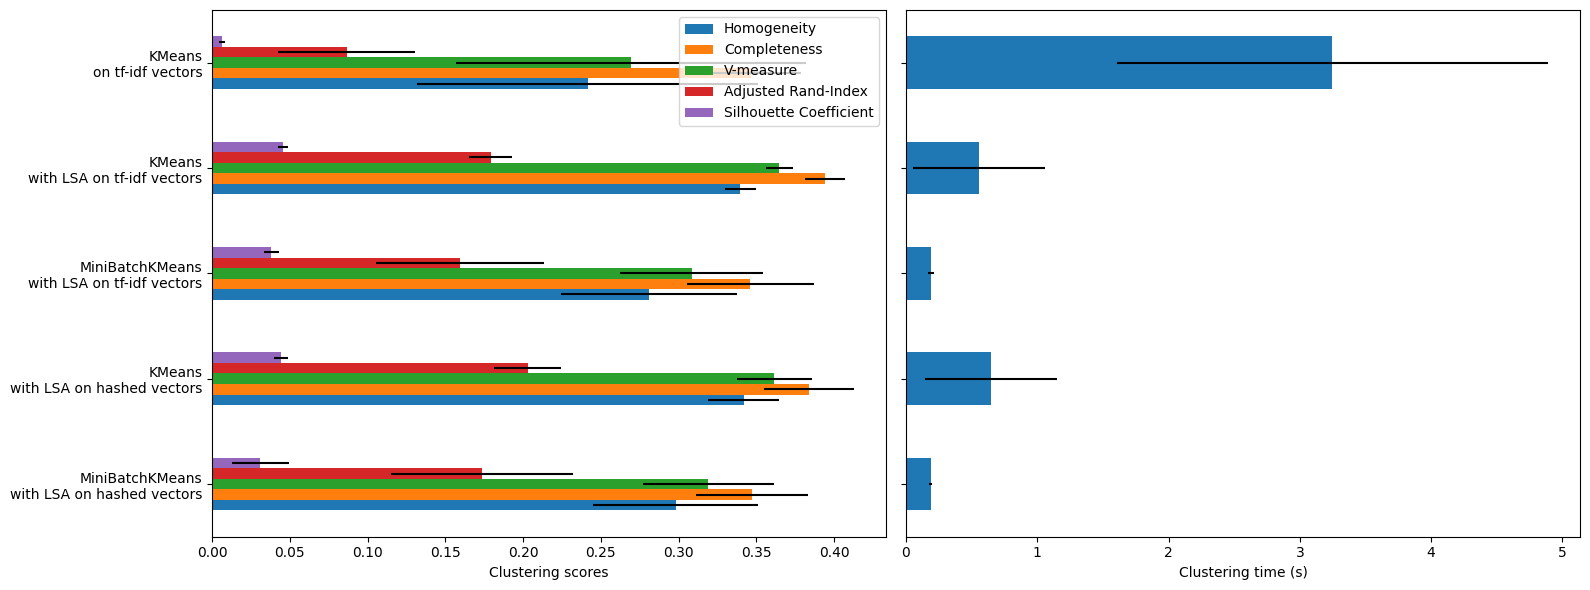

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(16, 6), sharey=True)

df = pd.DataFrame(evaluations[::-1]).set_index("estimator")
df_std = pd.DataFrame(evaluations_std[::-1]).set_index("estimator")

df.drop(
    ["train_time"],
    axis="columns",
).plot.barh(ax=ax0, xerr=df_std)
ax0.set_xlabel("Clustering scores")
ax0.set_ylabel("")

df["train_time"].plot.barh(ax=ax1, xerr=df_std["train_time"])
ax1.set_xlabel("Clustering time (s)")
plt.tight_layout()

## KMeans and MiniBatchKMeans suffer from the phenomenon called the Curse of Dimensionality for high dimensional datasets such as text data.
- That is the reason why the overall scores improve when using LSA. Using LSA reduced data also improves the stability and requires lower clustering time, though keep in mind that the LSA step itself takes a long time, especially with hashed vectors.

## The Silhouette Coefficient is defined between 0 and 1.
-  In all cases we obtain values close to 0 (even if they improve a bit after using LSA) because its definition requires measuring distances, in contrast with other evaluation metrics such as the V-measure and the Adjusted Rand Index which are only based on cluster assignments rather than distances.
- Notice that strictly speaking, one should not compare the Silhouette Coefficient between spaces of different dimension, due to the different notions of distance they imply.

## The homogeneity, completeness and hence v-measure metrics do not yield a baseline with regards to random labeling:
- this means that depending on the number of samples, clusters and ground truth classes, a completely random labeling will not always yield the same values. In particular random labeling won’t yield zero scores, especially when the number of clusters is large. This problem can safely be ignored when the number of samples is more than a thousand and the number of clusters is less than 10, which is the case of the present example. For smaller sample sizes or larger number of clusters it is safer to use an adjusted index such as the Adjusted Rand Index (ARI). See the example Adjustment for chance in clustering performance evaluation for a demo on the effect of random labeling.

## The size of the error bars show that MiniBatchKMeans is less stable than KMeans for this relatively small dataset. It is more interesting to use when the number of samples is much bigger, but it can come at the expense of a small degradation in clustering quality compared to the traditional k-means algorithm.